<>:52: SyntaxWarning: invalid escape sequence '\&'
<>:53: SyntaxWarning: invalid escape sequence '\&'
<>:54: SyntaxWarning: invalid escape sequence '\&'
<>:55: SyntaxWarning: invalid escape sequence '\&'
<>:57: SyntaxWarning: invalid escape sequence '\&'
<>:58: SyntaxWarning: invalid escape sequence '\&'
<>:59: SyntaxWarning: invalid escape sequence '\&'
<>:52: SyntaxWarning: invalid escape sequence '\&'
<>:53: SyntaxWarning: invalid escape sequence '\&'
<>:54: SyntaxWarning: invalid escape sequence '\&'
<>:55: SyntaxWarning: invalid escape sequence '\&'
<>:57: SyntaxWarning: invalid escape sequence '\&'
<>:58: SyntaxWarning: invalid escape sequence '\&'
<>:59: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipython-input-3674821745.py:52: SyntaxWarning: invalid escape sequence '\&'
  "TFF API \& Compatibility Errors",
/tmp/ipython-input-3674821745.py:53: SyntaxWarning: invalid escape sequence '\&'
  "FL Convergence \& Evaluation Mismatch",
/tmp/ipython-input-3674821745.py:54: SyntaxW

Found 9 files (sorted):
 - 1.csv
 - 2.csv
 - 3.csv
 - 4.csv
 - 5.csv
 - 6.csv
 - 7.csv
 - 8.csv
 - 9.csv

Year range: 2019 to 2025
Topics plotted: 9


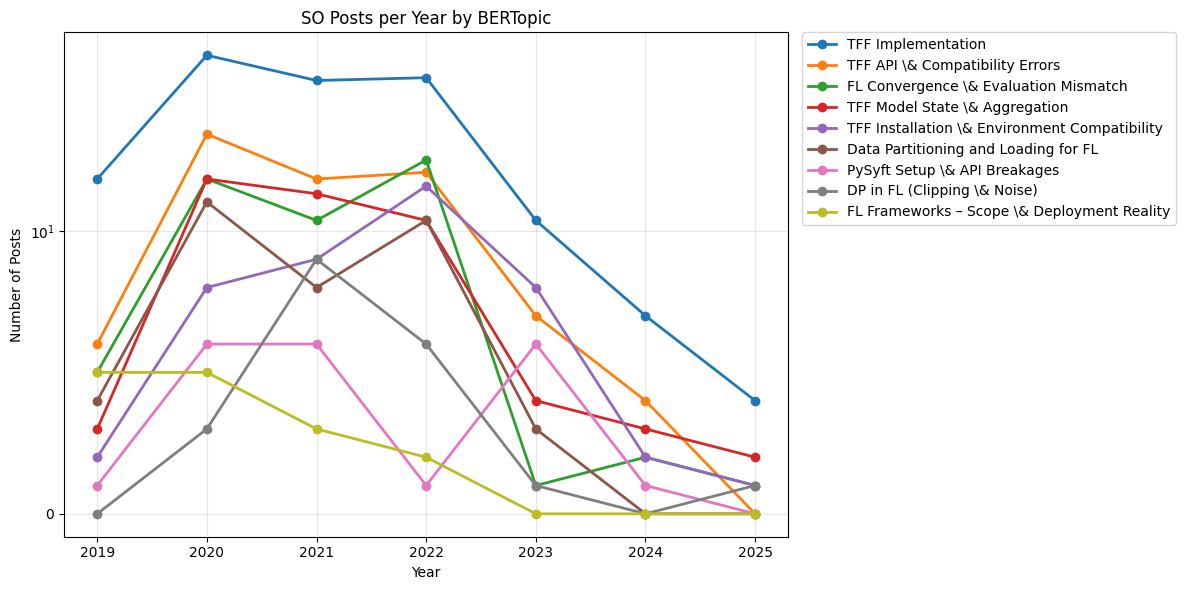

In [ ]:
# =========================
# 1) Imports
# =========================
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 2) Where your files are
# =========================
DATA_DIR = "/content"  # change this if your files are elsewhere, e.g. "/content/drive/MyDrive/bertopic_topics"

# =========================
# 3) Find your 13 files
# =========================
patterns = ["*.csv", "*.tsv", "*.xlsx", "*.xls"]
files = []
for pat in patterns:
    files.extend(glob.glob(os.path.join(DATA_DIR, pat)))

if len(files) == 0:
    raise FileNotFoundError(
        f"No files found in {DATA_DIR}. Upload your 9 files there or update DATA_DIR."
    )

files = sorted(files)

print(f"Found {len(files)} files (sorted):")
for f in files:
    print(" -", os.path.basename(f))

# =========================
# 4) Helper: read file robustly
# =========================
def read_table(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        return pd.read_csv(path)
    if ext == ".tsv":
        return pd.read_csv(path, sep="\t")
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    raise ValueError(f"Unsupported file type: {ext}")

# =========================
# 5) Topic display names (IN ORDER)
#    Important: this order will be matched to the sorted files list above.
# =========================
TOPIC_NAMES = [
    "TFF Implementation",
    "TFF API \& Compatibility Errors",
    "FL Convergence \& Evaluation Mismatch",
    "TFF Model State \& Aggregation",
    "TFF Installation \& Environment Compatibility",
    "Data Partitioning and Loading for FL",
    "PySyft Setup \& API Breakages",
    "DP in FL (Clipping \& Noise)",
    "FL Frameworks – Scope \& Deployment Reality",
]
# TOPIC_NAMES = [
#     "Topic 1",
#     "Topic 2",
#     "Topic 3",
#     "Topic 4",
#     "Topic 5",
#     "Topic 6",
#     "Topic 7",
#     "Topic 8",
#     "Topic 9",
# ]

if len(files) != len(TOPIC_NAMES):
    raise ValueError(
        f"Mismatch: found {len(files)} files but you provided {len(TOPIC_NAMES)} topic names.\n"
        f"Either remove extra files or update TOPIC_NAMES."
    )

# =========================
# 6) Build yearly counts per topic
# =========================
CREATED_COL = "CreationDate"   # change if your column name differs

series_by_topic = {}

for path, display_name in zip(files, TOPIC_NAMES):
    df = read_table(path)

    if CREATED_COL not in df.columns:
        candidates = [c for c in df.columns if c.lower() in ["CreationDate", "createdat", "created", "creation_time", "created time"]]
        if candidates:
            used_col = candidates[0]
        else:
            raise KeyError(
                f"'{CREATED_COL}' not found in {os.path.basename(path)}.\n"
                f"Available columns: {list(df.columns)}\n"
                f"Fix by setting CREATED_COL to the correct column name."
            )
    else:
        used_col = CREATED_COL

    dt = pd.to_datetime(df[used_col], errors="coerce", utc=True).dropna()
    if dt.empty:
        print(f"Warning: No valid dates parsed in {os.path.basename(path)} (column: {used_col}). Skipping.")
        continue

    years = dt.dt.year
    yearly_counts = years.value_counts().sort_index()
    series_by_topic[display_name] = yearly_counts

if len(series_by_topic) == 0:
    raise RuntimeError("No topics had parseable dates. Check your date column formatting.")

yearly_df = pd.DataFrame(series_by_topic).sort_index().fillna(0).astype(int)

print("\nYear range:", yearly_df.index.min(), "to", yearly_df.index.max())
print("Topics plotted:", len(yearly_df.columns))

# =========================
# 7) Plot: 13 lines (one per topic) with better visibility for small values
# =========================
plt.figure(figsize=(12, 6))

for topic in yearly_df.columns:
    plt.plot(yearly_df.index, yearly_df[topic], marker="o", linewidth=2, label=topic)

plt.title("SO Posts per Year by BERTopic")
plt.xlabel("Year")
plt.ylabel("Number of Posts")

plt.yscale("symlog", linthresh=10)  # linear near 0, log after ~10

plt.grid(True, which="both", alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

# (Optional) Save the figure
# plt.savefig("topics_by_year.png", dpi=200, bbox_inches="tight")
